In [41]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py, copy
import os, time, glob, pickle
from matplotlib import pyplot as plt

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.timing_tool import *
from alvra_tools.utils import *
from alvra_tools.YAG_scans import *
from alvra_tools.XAS_functions import *

import warnings
warnings.filterwarnings('ignore')

## choose runs to reduce

In [42]:
pgroup = 'p22285'

runlist = [73]
##############################################
from textwrap import wrap
from sfdata import SFScanInfo
jsonlist = []
for run in runlist:
    jsonfile = ''
    jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, run))[0]
    jsonlist.append(jsonfile)
print ("will reduce {} run(s): {}".format(len(jsonlist), runlist))
jsonlist

will reduce 1 run(s): [73]


['/sf/alvra/data/p22285/raw/run0073-SiN_overnight_3cycles_50regulation/meta/scan.json']

In [43]:
TT = TT_PSEN124

channel_delay_motor = channel_delay_beckhoff
detector_laser = channel_PALM_1
detector_Izero = channel_Izero122

reducedir= '/sf/alvra/data/{}/work/Reduced_data/'.format(pgroup)
saveflag = True

laser_pump, laser_unpump, Izero_pump, Izero_unpump, Delays_stage, arrTimes, Delays_corr = \
YAG_scanPP2(reducedir, saveflag, jsonlist, TT, channel_delay_motor, detector_laser, detector_Izero)

/sf/alvra/data/p22285/raw/run0073-SiN_overnight_3cycles_50regulation/meta/scan.json
Step 150 of 150: Processing acq0150

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet            25001 / 25003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude2 25001 / 25003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position2  25001 / 25003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-GES1:PR1_CH1_VAL_GET       25001 / 25003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY          25001 / 25003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-L-BECKBS:PR1_CH4_VAL_GET   25001 / 25003 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 24999 / 25003 -> 0% loss
complete channels: 0 / 6 -> 100% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 12499 pump and 12499 unpump shots
acq SFDataFiles("/sf/alvra/data/p22285/raw/run0073-SiN_overnight

In [64]:
pgroup = 'p22285'
Loaddir_name = ''

runlist = [73]
acqlist = np.arange(1,121)

chuncksize = 4  #len(acqlist)

quantile = 0.7

binsize = 2
min_delay = -400
max_delay = 400

variable_bins=False
numbins=100
####################################################
from lmfit.models import PseudoVoigtModel
acqchuncks = np.resize(acqlist, (len(acqlist)//chuncksize,chuncksize))

Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}'.format(pgroup, Loaddir_name)
t0 = []
w = []
t0_der = []
w_der = []
t0_voigt = []
w_voigt = []

for chunck in acqchuncks:
    clear_output(wait=True)
    data = {}
    globals().update(data)
    
    data, _ = load_reduced_data2(pgroup, Loaddir, runlist, chunck)
    globals().update(data)
    print ('Run {}, acq {}, {} total on/off shots'.format(runlist, chunck, len(laser_pump)))
    laser_pump   = np.asarray(laser_pump)
    laser_unpump = np.asarray(laser_unpump)
    Izero_pump   = np.asarray(Izero_pump)
    Izero_unpump = np.asarray(Izero_unpump)
    Delays_stage = np.asarray(Delays_stage)
    arrTimes     = np.asarray(arrTimes)
    Delays_corr  = np.asarray(Delays_corr)
    
    pp_TT, err_pp, Delay_fs_TT = rebin_and_filter_YAG(data, binsize, min_delay, max_delay, quantile, numbins, variable_bins)
    
    fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters)
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]
    
    # Fit the curve with function chosen before
    fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
    fit.p0 = better_p0(fit.p0, 4, 100)# overwrite some values (index) if needed: 
    fit.fit(Delay_fs_TT,pp_TT, maxfev=200000)                  # calculate the fit (put maxfev=# here if needed)
    t0.append(fit.popt[0])
    w.append(np.abs(fit.popt[2]))
    
    pp_TT_derivative = gaussian_filter1d(pp_TT,2, order = 1)
    parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [0, 0, 50, 0])
    t0_der.append(parameters_M2[0])
    w_der.append(np.abs(parameters_M2[2]*2.355))

    ## Pseudo Voigt fit of the derivative
    mod = PseudoVoigtModel()
    pars = mod.guess(pp_TT_derivative, x=Delay_fs_TT)
    init = mod.eval(pars, x=Delay_fs_TT)
    out = mod.fit(pp_TT_derivative, amplitude=0.0015, center= 0, sigma=0.4, fraction=0.5, x=Delay_fs_TT)

    t0_voigt.append(out.params.get('center').value)
    w_voigt.append(out.params.get('fwhm').value)
print ('----------------------------------')
print ('Fit:  {} - {:.2f} fs +/- {:.2f}, binsize {} fs'.format(np.round(w, decimals=2),np.nanmean(w), np.nanstd(w), binsize))
print ('Gauss:{} - {:.2f} fs +/- {:.2f}, binsize {} fs'.format(np.round(w_der, decimals=2),np.nanmean(w_der), np.nanstd(w_der), binsize))
print ('Voigt:{} - {:.2f} fs +/- {:.2f}, binsize {} fs'.format(np.round(w_voigt, decimals=2),np.nanmean(w_voigt), np.nanstd(w_voigt), binsize))

Run [73], acq [117 118 119 120], 49514 total on/off shots
20259 shots out of 39445 survived (total shots: 49514)
----------------------------------
Fit:  [ 75.71  80.23 500.65  78.21  77.31  80.09  79.25  77.75  80.96  79.2
  76.61  78.21  78.78  78.77  79.    78.44  78.83  76.9   76.92 175.56
  81.06  78.21  77.66  79.03  82.09  80.78  80.82  78.78  81.19  78.06] - 96.17 fs +/- 77.10, binsize 2 fs
Gauss:[ 72.    77.35  36.84  73.3   73.34  76.57  74.57  72.63  73.39  74.46
  69.41  74.52  75.86  74.95  74.37  70.82  72.53  69.74  72.48 170.16
  75.43  74.88  71.89  72.89  73.52  71.99  77.59  75.53  73.38  70.66] - 75.57 fs +/- 18.87, binsize 2 fs
Voigt:[69.42 74.44  4.59 70.33 70.41 73.45 71.7  69.67 70.33 71.3  66.32 71.21
 72.23 71.61 71.31 68.   69.06 66.9  69.48  4.45 72.07 71.32 68.67 69.68
 70.08 68.8  73.78 72.41 69.99 68.04] - 66.04 fs +/- 16.55, binsize 2 fs


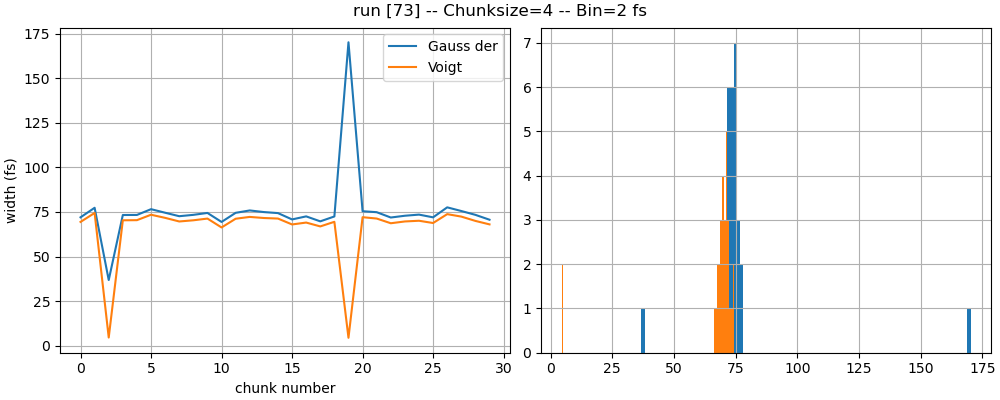

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
plt.suptitle('run {}'.format(runlist) + ' -- Chunksize={} -- Bin={} fs'.format(chuncksize, binsize))

ax1.plot(w_der, label='Gauss der')
ax1.plot(w_voigt, label='Voigt')
ax1.set_ylabel('width (fs)')
ax1.set_xlabel('chunk number')
ax1.legend(loc='best')
#ax1.set_ylim(40,140)
ax1.grid()

ax2.hist(w_der, bins=100)
ax2.hist(w_voigt, bins=100)
#ax2.set_xlim(0,1000)
ax2.grid()

In [60]:
from lmfit.models import PseudoVoigtModel

index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
Delay_fs_TT = Delay_fs_TT[index]
pp_TT=  pp_TT[index]

## Fit the curve with function chosen before
fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
fit.p0 = better_p0(fit.p0, 4, 200)# overwrite some values (index) if needed: 
#fit.p0 =[-80, 0.04, 50, 0.0, 500, 3e-5, 0.035]
#fit.p0 =[-80, 0.16, 100, 0.0, 200]
fit.fit(Delay_fs_TT,pp_TT, maxfev=200000)                  # calculate the fit (put maxfev=# here if needed)
pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting


## Gaussian fit of the derivative
pp_TT_derivative = gaussian_filter1d(pp_TT,2, order = 1)
parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [0, 0, 50, 0])

## Pseudo Voigt fit of the derivative
mod = PseudoVoigtModel()
pars = mod.guess(pp_TT_derivative, x=Delay_fs_TT)
init = mod.eval(pars, x=Delay_fs_TT)
out = mod.fit(pp_TT_derivative, amplitude=0.0005, center= 0, sigma=0.4, fraction=0.5, x=Delay_fs_TT)

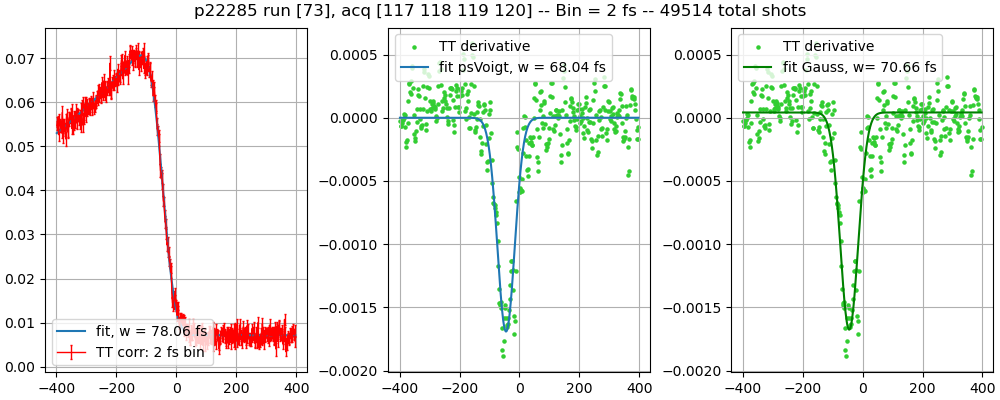

In [61]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)
fig.suptitle(pgroup + ' run {}, acq {} -- Bin = {} fs -- {} total shots'.format(runlist, chunck, binsize, len(laser_pump)))
ax1.errorbar(Delay_fs_TT, pp_TT, err_pp, 
              lw=1,color='red', markersize=0,capsize=1,capthick=1,
                   ecolor='red',elinewidth=1,label='TT corr: {} fs bin'.format(binsize))
ax1.plot(Delay_fs_TT, pp_fit, label = 'fit, w = {:.2f} fs'.format(fit.popt[2]))
ax1.legend(loc='lower left')
ax1.grid()

ax2.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT derivative', s = 5)
ax2.plot(Delay_fs_TT, out.best_fit, '-', label = 'fit psVoigt, w = {:.2f} fs'.format(out.params.get('fwhm').value))#, w= {:.2f} fs'.format(np.abs(pars[2])))
ax2.grid()
ax2.legend(loc='upper left')

ax3.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT derivative', s = 5)
ax3.plot(Delay_fs_TT, gaussian(Delay_fs_TT,*parameters_M2), color='green',\
         label = 'fit Gauss, w= {:.2f} fs'.format(np.abs(parameters_M2[2]*2.355)))

ax3.grid()
ax3.legend(loc='upper left')

In [51]:
pgroup='p22285'
runnumber = 73

#############################################################
print ('run: {:04d}'.format(runnumber))
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
run_name = jsonfile.split('/')[-3]
jsonfile

run: 0073


'/sf/alvra/data/p22285/raw/run0073-SiN_overnight_3cycles_50regulation/meta/scan.json'

In [52]:
channels_pp = [channel_Events, channel_PSEN126_arrTimes, channel_PSEN124_arrTimes, channel_PSEN124_arrTimesAmp, channel_PSEN126_arrTimesAmp, channel_Izero122]
channels_all = channels_pp

amp_thres = 4
i0_thres = 0.2

################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)

TTdiff = []
arrTimes1 = []
arrTimes2 = []
arr1 = []
arr2 = []

for i, step in enumerate(scan):
    check_files_and_data(step)
    check = get_filesize_diff(step)  
    if check:
        clear_output(wait=True)
        filename = scan.files[i][0].split('/')[-1].split('.')[0]
        print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
        resultsPP,_,_,_ = load_data_compact_pump_probe(channels_pp, channels_all, step)

        i0   = resultsPP[channel_Izero122].pump
        arr1 = resultsPP[channel_PSEN126_arrTimes].pump
        arr2 = resultsPP[channel_PSEN124_arrTimes].pump
        amp1 = resultsPP[channel_PSEN124_arrTimesAmp].pump
        amp2 = resultsPP[channel_PSEN126_arrTimesAmp].pump

        print (np.shape(arr1), np.shape(arr2))
        
        goodshots = np.logical_and.reduce ((i0 > i0_thres, amp1 > amp_thres, amp2 > amp_thres))
        arr1 = arr1[goodshots]
        arr2 = arr2[goodshots]

        print (np.shape(arr1), np.shape(arr2))
         
        arrTimes1.append(np.nanmean(arr1))
        arrTimes2.append(np.nanmean(arr2))

arrTimes1 = np.asarray(arrTimes1)
arrTimes2 = np.asarray(arrTimes2)


Step 150 of 150: Processing acq0150

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet            25001 / 25001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude  25001 / 25001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude2 25001 / 25001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position   25001 / 25001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position2  25001 / 25001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY          25001 / 25001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 25001 / 25001 -> 0% loss
complete channels: 6 / 6 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 12500 pump and 12500 unpump shots
(12500,) (12500,)
(0,) (0,)


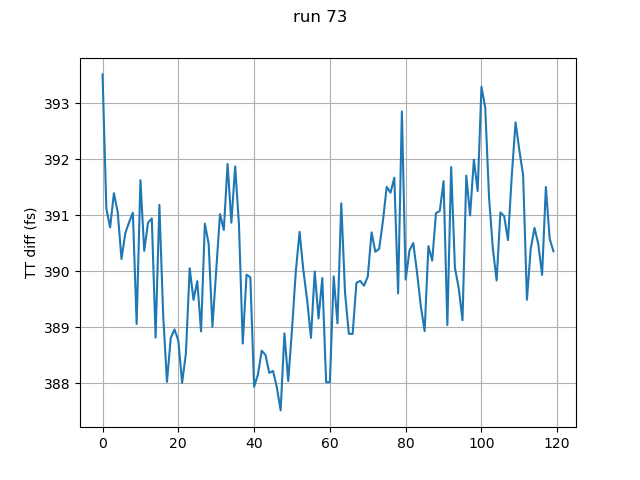

In [53]:
plt.figure()
plt.suptitle('run {}'.format(runnumber))
plt.plot(arrTimes1[:120] - arrTimes2[:120])
plt.ylabel('TT diff (fs)')
plt.grid()
plt.show()

# Load reduced runs

In [87]:
pgroup = 'p22285'
Loaddir_name = ''

runlist = [16]

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
from sfdata import SFScanInfo

scan = SFScanInfo(firstrun)

data = {}
globals().update(data)

data, titlestring_stack = load_reduced_data(pgroup, Loaddir, runlist)

globals().update(data)
print ('{} scan(s), {} total on/off shots'.format(len(runlist), len(laser_pump)))
laser_pump   = np.asarray(laser_pump)
laser_unpump = np.asarray(laser_unpump)
Izero_pump   = np.asarray(Izero_pump)
Izero_unpump = np.asarray(Izero_unpump)
Delays_stage = np.asarray(Delays_stage)
arrTimes     = np.asarray(arrTimes)
Delays_corr  = np.asarray(Delays_corr)

1 scan(s), 9422 total on/off shots


In [88]:
# Delay_fs = mm2fs(Delays_stage, get_timezero_NBS(firstrun))
# Delays_corr  = Delay_fs + arrTimes

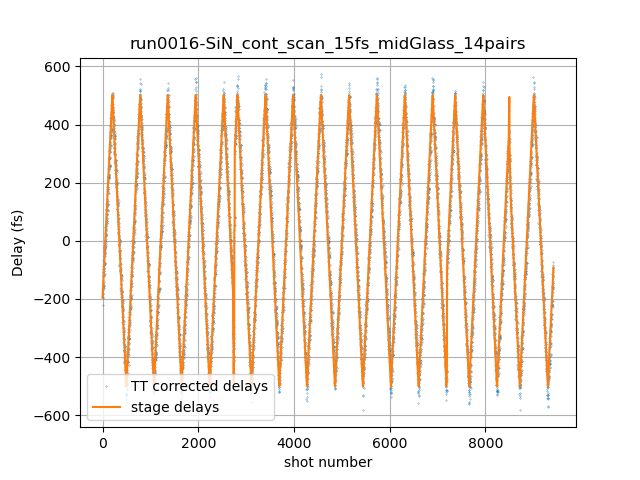

In [89]:
plt.figure()
plt.title(firstrun.split('/')[-3] )
plt.plot(Delays_corr, '.',ms=0.5, label = 'TT corrected delays')
plt.plot(Delays_stage, label = 'stage delays')
plt.xlabel('shot number')
plt.ylabel('Delay (fs)')
plt.legend (loc='best')
plt.grid()
plt.show()

In [90]:
quantile = 0.7

binsize = 5
min_delay = -500
max_delay = 500

variable_bins=False
numbins=100

pp_TT, err_pp, Delay_fs_TT = rebin_and_filter_YAG(data, binsize, min_delay, max_delay, quantile, numbins, variable_bins)

4455 shots out of 9110 survived (total shots: 9422)


In [91]:
# err function ---------------> [x0, amplitude, width, offset]
# exp_gauss_heaviside --------> [x0, amplitude, width, offset, lifetime]
# conv_exp_gauss_heaviside2 --> [x0, amplitude, width, offset, lifetime, a, b]

#fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
#fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)

In [92]:
from lmfit.models import PseudoVoigtModel

index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
Delay_fs_TT = Delay_fs_TT[index]
pp_TT=  pp_TT[index]

## Fit the curve with function chosen before
fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
fit.p0 = better_p0(fit.p0, 4, 200)# overwrite some values (index) if needed: 
#fit.p0 =[-80, 0.04, 50, 0.0, 500, 3e-5, 0.035]
#fit.p0 =[-80, 0.16, 100, 0.0, 200]
fit.fit(Delay_fs_TT,pp_TT, maxfev=200000)                  # calculate the fit (put maxfev=# here if needed)
pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting


## Gaussian fit of the derivative
pp_TT_derivative = gaussian_filter1d(pp_TT,2, order = 1)
parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [0, 0, 50, 0])

## Pseudo Voigt fit of the derivative
mod = PseudoVoigtModel()
pars = mod.guess(pp_TT_derivative, x=Delay_fs_TT)
init = mod.eval(pars, x=Delay_fs_TT)
out = mod.fit(pp_TT_derivative, amplitude=0.0005, center= 0, sigma=0.4, fraction=0.5, x=Delay_fs_TT)

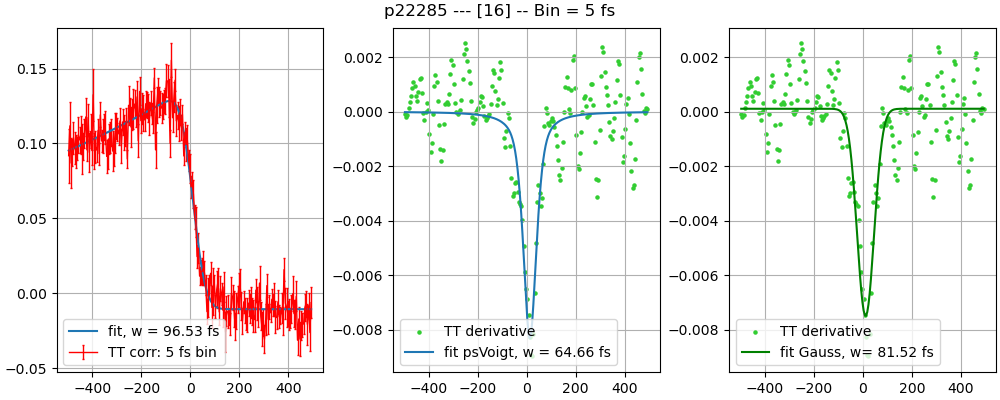

In [93]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)
fig.suptitle(titlestring_stack + ' -- Bin = {} fs'.format(binsize))
ax1.errorbar(Delay_fs_TT, pp_TT, err_pp, 
              lw=1,color='red', markersize=0,capsize=1,capthick=1,
                   ecolor='red',elinewidth=1,label='TT corr: {} fs bin'.format(binsize))
ax1.plot(Delay_fs_TT, pp_fit, label = 'fit, w = {:.2f} fs'.format(fit.popt[2]))
ax1.legend(loc='lower left')
ax1.grid()

ax2.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT derivative', s = 5)
ax2.plot(Delay_fs_TT, out.best_fit, '-', label = 'fit psVoigt, w = {:.2f} fs'.format(out.params.get('fwhm').value))#, w= {:.2f} fs'.format(np.abs(pars[2])))
ax2.grid()
ax2.legend(loc='lower left')

ax3.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT derivative', s = 5)
ax3.plot(Delay_fs_TT, gaussian(Delay_fs_TT,*parameters_M2), color='green',\
         label = 'fit Gauss, w= {:.2f} fs'.format(np.abs(parameters_M2[2]*2.355)))

ax3.grid()
ax3.legend(loc='lower left')

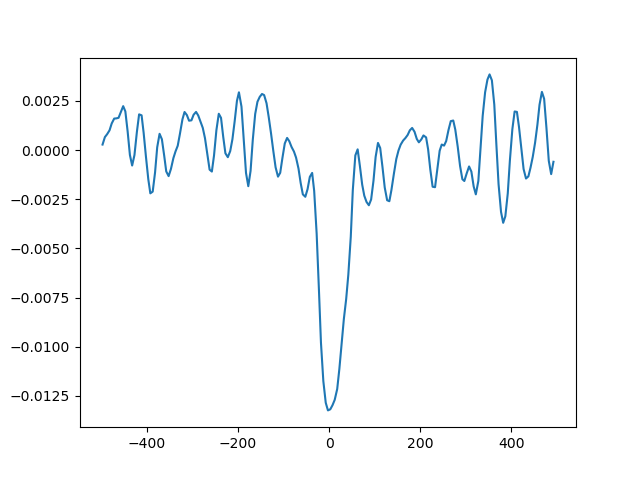

In [135]:
plt.figure()
plt.plot(Delay_fs_TT, pp_TT_derivative)
plt.show()